## IV. Methodology

### 4.1 Dataset Preparation
* ~Load the clean EEG, EOG, and EMG data from the EEGDenoiseNet dataset in .npy format.~
### 4.2 Contaminated Signal Generation
For each selected clean EEG segment:
* ~Randomly select an artifact segment from each chosen type.~
* ~Calculate the contaminated signal using the formula: contaminated_signal = clean_eeg + λ * artifact_segment.~
* ~Randomly generate and use λ value. Then calculate the SNR of the generated contaminated signal.~
* ~With the new array of contaminated signals, drop those that are out of the typical SNR range:~
    * Ocular artifacts: [-7 to 2]
    * Mygoenic artifact: [-7 to 4]

### 4.3 Denoising Methods
#### 4.3.1 Empirical Mode Decomposition
* Apply EMD to the contaminated EEG signal to decompose it into intrinsic mode functions (IMFs).
* Analyze the IMFs to identify and remove artifacts or noise components.
* Reconstruct the denoised EEG signal using the remaining IMFs.
* Measure the processing time and SNR of the denoised signal.

#### 4.3.2 Independent Component Analysis
* Apply ICA to the contaminated EEG signal to extract independent components.
* Identify the components representing the EEG signal.
* Reconstruct the denoised EEG signal using the selected components.
* Measure the processing time and SNR of the denoised signal.

### 4.4 Evaluation
* Calculate the SNR of the denoised EEG signals using appropriate metrics such as the ratio of signal power to noise power.
* Compare the SNR performance and processing time of ICA and EMD for denoising the EEG signals.
* Analyze the results and draw conclusions regarding the denoising effectiveness and efficiency of each method.

### 4.1 Dataset Preparation

In [63]:
import random
import numpy as np
from PyEMD import EMD
import matplotlib.pyplot as plt
import memory_profiler
import time
from memory_profiler import memory_usage

In [5]:
eeg = np.load('EEGDenoiseNet/EEG_all_epochs.npy')
print(f"------EEG-----\nSize: {eeg.size}\nRow count: {len(eeg)}\nColumn count: {len(eeg[0])}\nFirst Column: {eeg[:, 0]}\n\n")

emg = np.load('EEGDenoiseNet/EMG_all_epochs.npy')
print(f"------EMG(Heart)-----\nSize: {emg.size}\nRow count: {len(emg)}\nColumn count: {len(emg[0])}\nFirst Column: {emg[:, 0]}\n\n")

eog = np.load('EEGDenoiseNet/EOG_all_epochs.npy')
print(f"------EOG(Ocular)-----\nSize: {eog.size}\nRow count: {len(eog)}\nColumn count: {len(eog[0])}\nFirst Column: {eog[:, 0]}")

------EEG-----
Size: 2311168
Row count: 4514
Column count: 512
First Column: [184.5070843  171.96198926 229.56731921 ... 317.59704985 262.89154388
 216.07429779]


------EMG(Heart)-----
Size: 2866176
Row count: 5598
Column count: 512
First Column: [20245.96672667 23595.64263225 34991.76745427 ...  1490.61150022
   -38.705385    1260.54203952]


------EOG(Ocular)-----
Size: 1740800
Row count: 3400
Column count: 512
First Column: [  7.30828446  -1.68701752  12.4808031  ...   6.81209745 298.19922839
 -44.54226777]


### 4.2 Contaminated Signal Generation

* Randomly select an artifact segment from each chosen type.
* Calculate the contaminated signal using the formula: contaminated_signal = clean_eeg + λ * artifact_segment.
* Randomly generate and use λ value. Then calculate the SNR of the generated contaminated signal.

In [6]:
def get_random_rows(dataset, num_rows):
    num_total_rows = dataset.shape[0]
    selected_indices = np.random.choice(num_total_rows, size=num_rows, replace=False)
    selected_rows = dataset[selected_indices, :]
    return selected_rows


def calculate_snr(clean_eeg, artifact_segment,λ):
    N = 512
    # Calculate the signal power (clean EEG)
    signal_power = (np.sum(clean_eeg ** 2)*(1/N))**0.5
    # Calculate the noise power (artifact segment)
    noise_power = (np.sum((λ*artifact_segment)**2)*(1/N))**0.5
    # Calculate the SNR in dB (RMS FORMULA)
    snr_db = 10 * np.log10(signal_power / noise_power)
    return round(snr_db,2)

def generate_contaminated_signal(clean_eeg_data,artifact_data,num_samples:int, artifact_type:str):
    num_clean_eeg_samples = clean_eeg_data.shape[0]
    num_eog_artifacts = artifact_data.shape[0]

    contaminated_eeg_data = []
    contamination_indices = []
    snr_values=[]

    for i in range(num_samples):
        clean_eeg_index = np.random.randint(0, num_clean_eeg_samples)
        eog_artifact_index = np.random.randint(0, num_eog_artifacts)

        clean_eeg_sample = clean_eeg_data[clean_eeg_index]
        artifact = artifact_data[eog_artifact_index]

        #GENERATE RANDOM LAMBDA VALUE HERE
        λ = random.uniform(-40,40)
        #GENERATE CONTAMINATED SIGNAL USING FORMULA: y=x+(λ*n)
        contaminated_eeg_sample = clean_eeg_sample + (artifact*λ)
        snr=calculate_snr(clean_eeg_data,artifact,λ)

        contaminated_eeg_data.append(contaminated_eeg_sample)
        contamination_indices.append((clean_eeg_index, eog_artifact_index))
        snr_values.append(snr)
    return np.array(contaminated_eeg_data), contamination_indices, snr_values, artifact_type

In [7]:
contaminated_eeg_data,indices,snr_values,artifact_type = generate_contaminated_signal(eeg,eog,100000,'ocular')
print(f"{contaminated_eeg_data}\nSNR Values: {snr_values}\nArtifact Type: {artifact_type}")

[[ -101.71281517  -200.45590372  -150.25098725 ...   117.44895731
    103.05579797   245.47586119]
 [ 6467.86379061  9512.35348258  9038.93395665 ... -2310.00552017
  -2217.4711492  -2286.33796073]
 [  -98.58135946  -217.38298595  -345.14120006 ...  -291.15015108
   -166.04513276   -86.45475031]
 ...
 [ -189.7614018   -271.90112415  -171.64798926 ...  -150.99530666
    -72.43929227   -32.68733187]
 [ 1231.95755811  1984.50700087  2243.79448291 ...  1845.73163509
   1400.97714532  1280.99093542]
 [  116.75127865   123.92384886   131.14071939 ...  1090.80007216
   1021.32176349  1083.9848621 ]]
SNR Values: [16.28, 6.45, 20.27, 8.1, 14.62, 5.0, 7.31, 15.35, 6.81, 6.88, 6.57, 7.69, 11.02, 10.41, 8.23, 16.18, 19.72, 2.64, 20.02, 18.5, 8.33, 24.58, 3.87, 12.8, 8.63, 9.08, 9.76, 11.5, 13.87, 6.55, 4.23, 6.53, 9.81, 9.19, 5.98, 10.28, 7.89, 6.9, 9.94, 9.85, 8.54, 3.65, 10.39, 2.16, 8.0, 8.87, 5.65, 6.08, 11.43, 12.76, 17.6, 5.58, 11.89, 18.12, 6.99, 4.45, 5.89, 8.46, 18.0, 10.9, 6.36, 7.59, 11

* With the new array of contaminated signals, drop those that are out of the typical SNR range:
    * Ocular artifacts: [-7 to 2]
    * Mygoenic artifact: [-7 to 4]


**Specific Steps**
* ~Find the data type of `contaminated_eeg_data`, `indices`, `snr_values`, `artifact_type`~
    * **array**: `contaminated_eeg_data`
    * **list**: `indices`, `snr_values`
    * **tuple**: elements inside `indices`
    * **string**: `artifact_type`
* ~Go through `snr_values`. If it goes out the range of the given value, find the index of that value.~
 * ~Use that index to drop values from `contaminated_eeg_data`, `indices`, `snr_values`, and `artifact_type`~
* ~Find the length of the new array and take n samples from this. This will be your sample size.~

In [47]:
count, out_of_range = 0,len(contaminated_eeg_data)
contaminated_data2,indices2,snr_values2 = [],[],[]
if artifact_type =='ocular':
    snr_range = [-7,2]
elif artifact_type == 'myogenic':
    snr_range = [-7,4]

for i in snr_values:
    if i>=snr_range[0] and i<=snr_range[1]:
        index=snr_values.index(i)
        count+=1
        out_of_range-=1
        contaminated_data2.append(contaminated_eeg_data[index])
        indices2.append(indices[index])
        snr_values2.append(snr_values[index])
    if len(contaminated_data2)==2000:
        break

print(f"Original size: {len(contaminated_eeg_data)}\nNumber of out of range SNR values: {out_of_range}\nRemaining sample size: {count}")

print(f'\nSAMPLE SIZE OR New length of contaminated_eeg_data: {len(contaminated_data2)}')

Original size: 100000
Number of out of range SNR values: 98000
Remaining sample size: 2000

SAMPLE SIZE OR New length of contaminated_eeg_data: 2000


### 4.3 Denoising Algorithms

#### 4.3.1 Empirical Mode Decomposition

* Apply EMD to the contaminated EEG signal to decompose it into intrinsic mode functions (IMFs) and a residual or trend.
* Analyze the IMFs to identify and remove artifacts or noise components.
* Reconstruct the denoised EEG signal using the remaining IMFs.
* Measure the processing time and SNR of the denoised signal.

**NOTES**
* `IMF` is a numpy array that contains `n` numbers of `imf`s.
* `imf` is a numpy array that is a subset of imf that contains the actual signal inputs.
* In the following example, `IMF` has 7 elements or `imf`s. Each `imf` file contains 512 rows.

**SPECIFIC STEPS**
* Create an empty list to put the IMFs to be generated.
* Create a function that goes through every row of `contaminated_data2`.
    * Denoise the given `contaminated_data2` row into IMFs.
    * Use: ```n, imf = emurate(IMF)```

Memory usage during EMD: 9.33 MB
Execution time of EMD: 0.24 seconds


/var/folders/y0/hqzvd0zj4gd8wqkm8l5zck3c0000gn/T/ipykernel_9761/3992849849.py:49: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


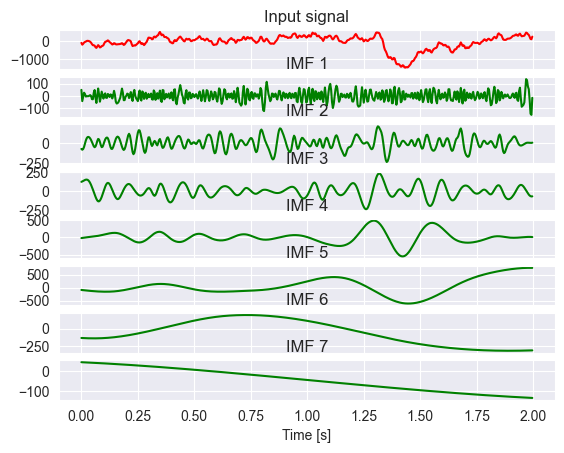

In [65]:
# DEFINE SIGNAL
t = np.arange(0, duration, 1/sampling_rate)
s = contaminated_data2[0]

# Function to calculate the EMD and get memory usage
def emd_with_memory_usage(s, t):
    # Create an instance of EMD with specific settings
    emd = EMD(DTYPE=np.float16, max_imfs=2)

    # Start memory usage recording
    mem_usage_start = memory_usage()[0]

    # Perform EMD
    IMF = emd.emd(s, t)

    # End memory usage recording
    mem_usage_end = memory_usage()[0]

    # Calculate memory usage during EMD process
    mem_usage_emd = mem_usage_end - mem_usage_start

    return IMF, mem_usage_emd

# Measure time and memory usage for EMD
start_time = time.time()
IMF, memory_usage_emd = emd_with_memory_usage(s, t)
end_time = time.time()
execution_time = end_time - start_time

N = IMF.shape[0] + 1

# Print memory usage and execution time
print("Memory usage during EMD: {:.2f} MB".format(memory_usage_emd))
print("Execution time of EMD: {:.2f} seconds".format(execution_time))

# Plot results
plt.subplot(N,1,1)
plt.plot(t, s, 'r')
#plt.title("Input signal: $S(t)=cos(22\pi t^2) + 6t^2$")
plt.title("Input signal")
plt.xlabel("Time [s]")

for n, imf in enumerate(IMF):
    plt.subplot(N,1,n+2)
    plt.plot(t, imf, 'g')
    plt.title("IMF "+str(n+1))
    plt.xlabel("Time [s]")

plt.tight_layout()
plt.savefig('simple_example')
plt.show()

#### 4.3.2 Independent Component Analysis

#### 4.4 Evaluation